In [1]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats
import seaborn as sn

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

sn.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [13]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    #'Random Logit', not all csv in local (Julien)
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    #'Monotonicity Arya', not all csv in local (Julien)
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed
    
transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

aggregate = {
    'Monotonicity Nguyen': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Local Lipschitz Estimate': np.mean,
    'Faithfulness Estimate': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Faithfulness Correlation': lambda x: np.tanh(np.mean(np.arctanh(x))),
    'Avg-Sensitivity': np.mean,
    'Random Logit': np.mean,
    'Max-Sensitivity': np.mean,
    'Sparseness': np.mean, 
    'EffectiveComplexity': np.mean,
    'Monotonicity Arya': np.mean,
    'Complexity': np.mean,
    'Pixel-Flipping': np.mean,
    'Selectivity': np.mean,
    'Model Parameter Randomisation': np.mean
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

group_nemenyi = {}

dataset = "imagenet"
for metr in metrics: #metrics:
    print("-- Metric: ", metr)
    scores = []
    for meth in methods:
        csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
        df = pd.read_csv(csv_name, header = None)
        data = transform[metr](df).values.flatten()
        scores.append(-aggregate[metr](data))

    #data_nemenyi = transform[metr](data_nemenyi)
    
    dico_ranks[metr] = rankdata(scores)

df_ranks = pd.DataFrame(dico_ranks, index= methods)

#compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen
-- Metric:  Local Lipschitz Estimate
-- Metric:  Faithfulness Estimate
-- Metric:  Faithfulness Correlation
-- Metric:  Avg-Sensitivity
-- Metric:  Max-Sensitivity
-- Metric:  Sparseness
-- Metric:  EffectiveComplexity
-- Metric:  Complexity
-- Metric:  Pixel-Flipping
-- Metric:  Selectivity
-- Metric:  Model Parameter Randomisation


In [14]:
df_ranks

,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Max-Sensitivity,Sparseness,EffectiveComplexity,Complexity,Pixel-Flipping,Selectivity,Model Parameter Randomisation
integratedgrad,7.0,2.0,9.0,8.0,2.0,2.0,2.0,5.0,2.0,3.0,2.0,9.0
smoothgrad,1.0,4.0,6.0,6.0,1.0,1.0,8.0,10.0,8.0,5.0,4.0,2.0
guidedbackprop,6.0,1.0,10.0,10.0,3.0,3.0,1.0,3.0,1.0,1.0,3.0,11.0
rise,8.0,10.0,5.0,2.0,11.0,11.0,11.0,8.0,10.0,6.0,5.0,7.0
gradcam,2.0,6.0,1.0,1.0,5.0,5.0,4.0,2.0,4.0,10.0,11.0,4.0
scorecam,4.0,7.0,4.0,4.0,6.0,6.0,6.0,4.0,6.0,11.0,10.0,3.0
layercam,3.0,9.0,3.0,5.0,8.0,8.0,9.0,10.0,9.0,9.0,9.0,5.0
random,11.0,8.0,11.0,11.0,7.0,7.0,7.0,7.0,7.0,2.0,1.0,10.0
sobel,10.0,3.0,8.0,9.0,10.0,10.0,3.0,1.0,3.0,4.0,6.0,6.0
gaussian,9.0,11.0,2.0,7.0,9.0,9.0,10.0,10.0,11.0,7.0,7.0,1.0


In [8]:
scores

[-2038.2498005715067,
 -5022.822591537432,
 -1986.6801448739598,
 -20384.11712538437,
 -11855.065430000484,
 -13013.713239941408,
 -19493.216848286553,
 -16335.259760009953,
 -3649.733582455337,
 -24344.089224287323,
 -8841.004395051728]

In [15]:
tau_values = []
p_values = []

for metric_a in metrics:
    current_tau_values = []
    current_p_values = []
    for metric_b in metrics:
        tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
        current_tau_values.append(tau)
        current_p_values.append(p_value)
    tau_values.append(current_tau_values)
    p_values.append(current_p_values)

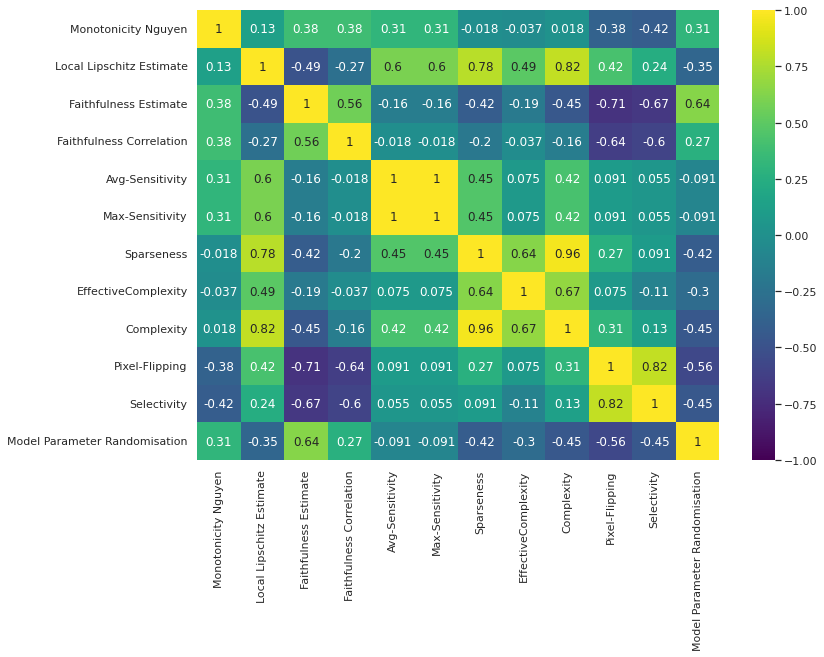

In [16]:
# Correlation Matrix
sn.heatmap(tau_values, annot=True, vmin=-1, vmax=1, xticklabels=metrics, yticklabels=metrics, cmap='viridis')
plt.show()

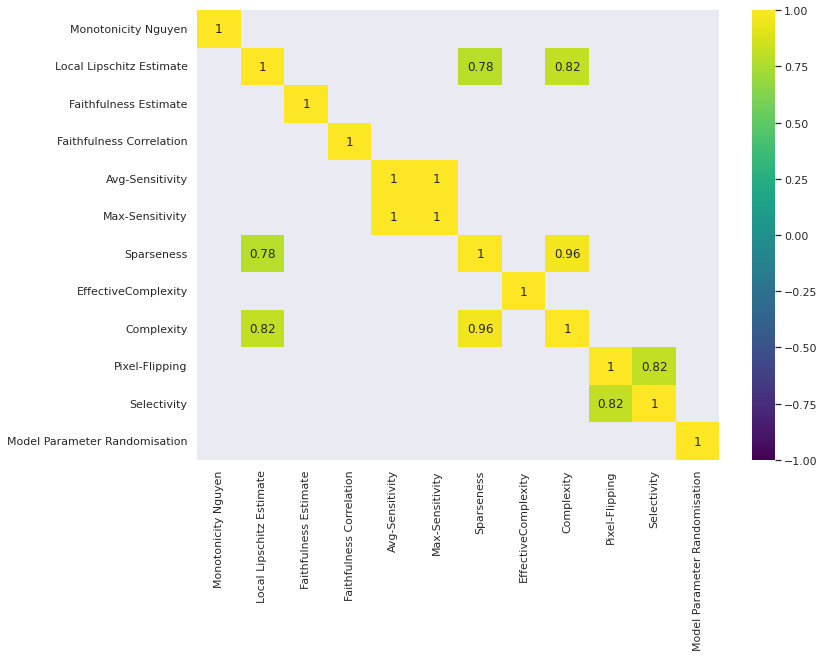

In [17]:
# Correlation Matrix with only significative values
p_threshold = 0.05 / len(metrics) ** 2 
p_values_mask = []
for sublist in p_values:
    p_values_mask.append([p_value > p_threshold for p_value in sublist])
    
p_values_mask = np.array(p_values_mask)

sn.heatmap(tau_values, annot=True, vmin=-1, vmax=1, xticklabels=metrics, yticklabels=metrics, mask=p_values_mask, cmap='viridis')
plt.show()

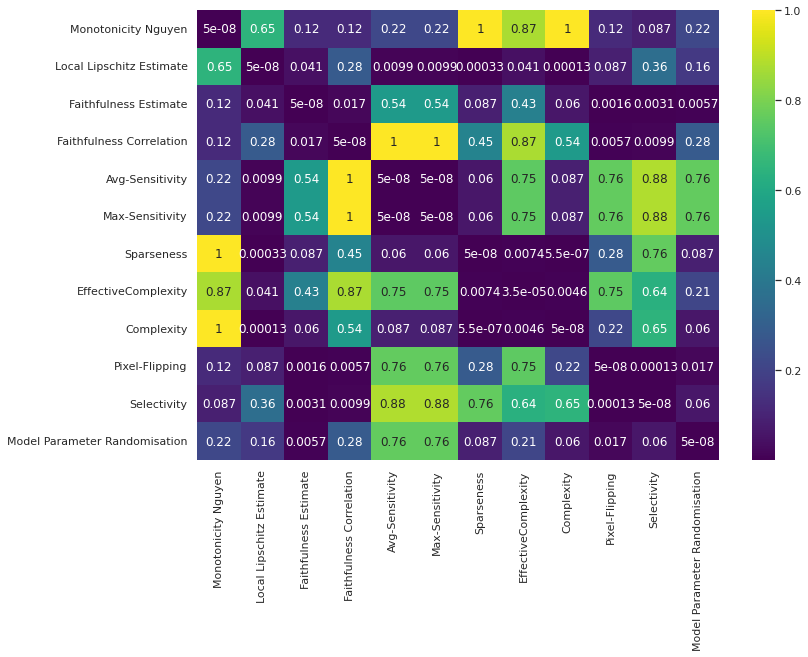

In [18]:
# Matrix of the p_values
sn.heatmap(p_values, annot=True, xticklabels=metrics, yticklabels=metrics, cmap='viridis')
plt.show()